<a href="https://colab.research.google.com/drive/1bARAHvLvMosct4SGYcLZ3xbRkCxPjbAZ" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Useful Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.3.0


# Download and show data

Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


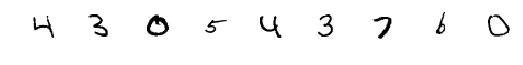

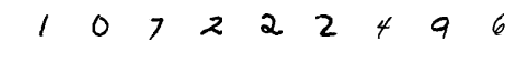

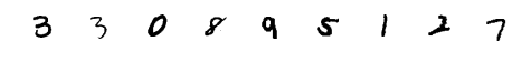

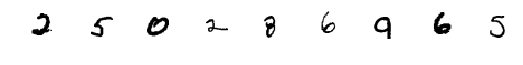

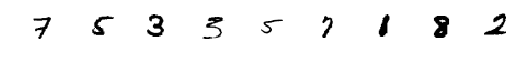

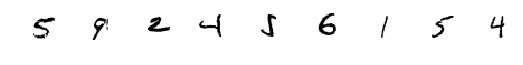

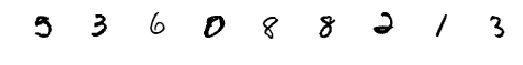

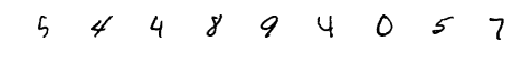

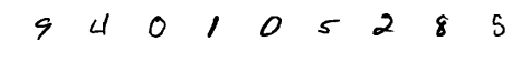

In [3]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainY), (testX, testY) = mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))

for k in range(9):
    plt.figure(figsize=(9, 6))
    for j in range(9):
        i = np.random.randint(0, 10000)
        plt.subplot(990 + 1 + j)
        plt.imshow(trainX[i], cmap='gray_r')
        #plt.title(trainY[i])
        plt.axis('off')
    plt.show()

# 10 Classes

In [4]:
#Ten classes
set(trainY)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

# Data Normalization

In [5]:
trainX = [(image-127.5)/127.5 for image in trainX]
testX = [(image-127.5)/127.5 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


# Define Generator Model

In [6]:
random_input = tensorflow.keras.layers.Input(shape = 50)
control_input = tensorflow.keras.layers.Input(shape = 10)

x1 = tensorflow.keras.layers.Dense(64)(random_input)

#Class Input
x2 = tensorflow.keras.layers.Dense(32)(control_input)

x = tensorflow.keras.layers.Concatenate()([x1, x2])

x = tensorflow.keras.layers.Dense(5*5*64)(x)
x = tensorflow.keras.layers.Activation('relu')(x)

x = tensorflow.keras.layers.Reshape((5, 5, 64))(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=2)(x)
x = tensorflow.keras.layers.Activation('relu')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=2)(x)
x = tensorflow.keras.layers.Activation('relu')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3,3))(x)
x = tensorflow.keras.layers.Activation('relu')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(4,4))(x)
generated_image = tensorflow.keras.layers.Activation('tanh')(x)

generator_network = tensorflow.keras.models.Model(inputs=[random_input, control_input], outputs=generated_image)
generator_network.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           3264        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           352         input_2[0][0]                    
_______________________________________________________________________________________

# Define Discriminator

In [7]:
image_input = tensorflow.keras.layers.Input(shape=(28, 28, 1))

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=2)(image_input)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=2)(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3))(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(4,4))(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

features = tensorflow.keras.layers.Flatten()(x)

d_out = tensorflow.keras.layers.Dense(1)(features)
real_vs_fake_output = tensorflow.keras.layers.Activation('sigmoid')(d_out)

discriminator_network = tensorflow.keras.models.Model(inputs=image_input, outputs=real_vs_fake_output)

info = tensorflow.keras.layers.Dense(10)(features)
info_output = tensorflow.keras.layers.Activation('softmax')(info)

info_network = tensorflow.keras.models.Model(inputs=image_input, outputs=info_output)

print (discriminator_network.summary())
print (info_network.summary())

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 13, 13, 128)       1280      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 128)         147584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6, 6, 128)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 6, 6, 128)         512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)        

In [8]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_network.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

info_network.compile(loss='categorical_crossentropy', optimizer=adam_optimizer)

# Define combined model: Info-GAN

In [ ]:
discriminator_network.trainable=False

g_output = generator_network([random_input, control_input])

d_output = discriminator_network(g_output)
info_output = info_network(g_output)

info_gan_model = tensorflow.keras.models.Model(inputs = [random_input, control_input], outputs=[d_output, info_output])
info_gan_model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 28, 28, 1)    531425      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 1)            428929      functional_1[0][0]    

# Compiling InfoGAN

In [ ]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
info_gan_model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=adam_optimizer)

# Define Utility Functions

In [ ]:
indices = [i for i in range(0, len(trainX))]

def encode_control_input(value):
    x = np.zeros((10))
    x[value]=1
    return x

def decode_control_input(value):
    return np.where(value==1)[0][0]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batches = np.reshape(random_values, (batch_size, noise_size))
    control_inputs = []
    for i in range(batch_size):
        control_input = np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], size=1)
        control_inputs.append(encode_control_input(control_input))
    control_inputs = np.array(control_inputs)
    return random_noise_batches, control_inputs

def get_fake_samples(generator_network, batch_size, noise_size):
    random_noise_batches, control_inputs= get_random_noise(batch_size, noise_size) 
    fake_samples = generator_network.predict_on_batch([random_noise_batches, control_inputs])
    return fake_samples

def get_real_samples(batch_size):
    random_indices = np.random.choice(indices, size=batch_size)
    real_images = trainX[np.array(random_indices),:]
    return real_images

def show_generator_results(generator_network):
    for k in range(10):
        random_noise_batches, _ = get_random_noise(10, noise_size) 
        control_inputs = []
        for bs in range(10):
            control_inputs.append(encode_control_input(k))
        control_inputs = np.array(control_inputs)
        fake_samples = generator_network.predict_on_batch([random_noise_batches, control_inputs])
        plt.figure(figsize=(9, 6))
        for j in range(9):
            i = j
            plt.subplot(990 + 1 + j)
            plt.imshow(fake_samples[i,:,:,-1], cmap='gray_r')
            #plt.title(decode_control_input(control_inputs[i]))
            plt.axis('off')
        plt.show()
    return

# Training Info-GAN

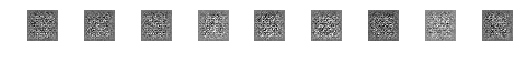

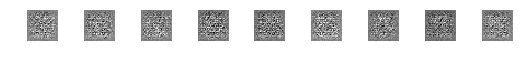

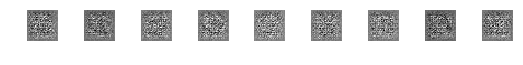

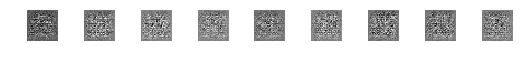

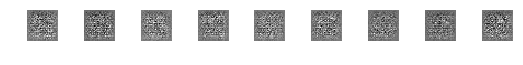

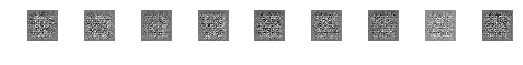

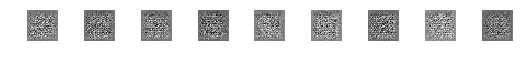

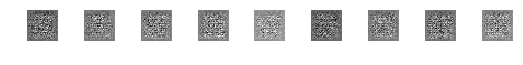

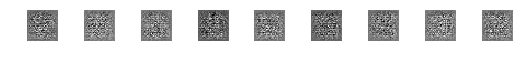

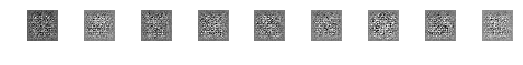

Epoch:0, Step:0, D-Loss:0.717, D-Acc:80.000, G-Loss:2.985, Info-Loss:0.656
Epoch:0, Step:50, D-Loss:0.152, D-Acc:96.000, G-Loss:7.191, Info-Loss:4.368
Epoch:0, Step:100, D-Loss:0.120, D-Acc:95.000, G-Loss:7.358, Info-Loss:4.810
Epoch:0, Step:150, D-Loss:0.061, D-Acc:99.000, G-Loss:7.458, Info-Loss:4.964
Epoch:0, Step:200, D-Loss:0.092, D-Acc:97.000, G-Loss:8.082, Info-Loss:5.603
Epoch:0, Step:250, D-Loss:0.073, D-Acc:99.000, G-Loss:7.589, Info-Loss:5.276
Epoch:0, Step:300, D-Loss:0.127, D-Acc:96.000, G-Loss:6.582, Info-Loss:4.307
Epoch:0, Step:350, D-Loss:0.070, D-Acc:99.000, G-Loss:6.053, Info-Loss:4.181
Epoch:0, Step:400, D-Loss:0.109, D-Acc:98.000, G-Loss:5.605, Info-Loss:3.673
Epoch:0, Step:450, D-Loss:0.084, D-Acc:98.000, G-Loss:6.656, Info-Loss:4.760


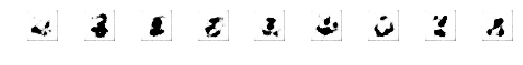

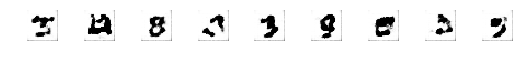

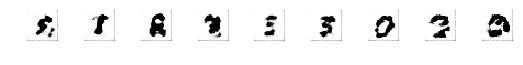

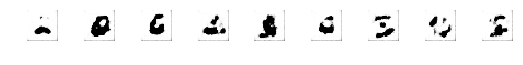

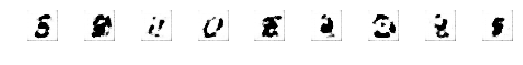

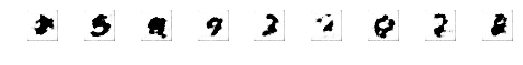

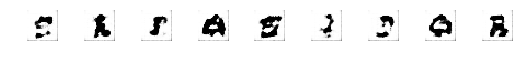

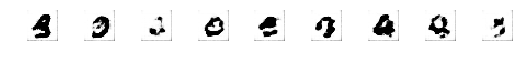

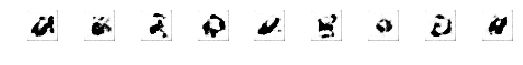

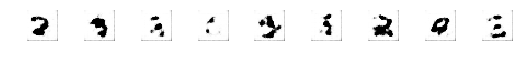

Epoch:1, Step:0, D-Loss:0.065, D-Acc:97.000, G-Loss:6.239, Info-Loss:4.509
Epoch:1, Step:50, D-Loss:0.073, D-Acc:98.000, G-Loss:5.500, Info-Loss:3.640
Epoch:1, Step:100, D-Loss:0.068, D-Acc:98.000, G-Loss:6.645, Info-Loss:5.091
Epoch:1, Step:150, D-Loss:0.163, D-Acc:94.000, G-Loss:4.425, Info-Loss:2.985
Epoch:1, Step:200, D-Loss:0.096, D-Acc:98.000, G-Loss:6.921, Info-Loss:5.416
Epoch:1, Step:250, D-Loss:0.127, D-Acc:95.000, G-Loss:4.828, Info-Loss:3.410
Epoch:1, Step:300, D-Loss:0.211, D-Acc:92.000, G-Loss:4.715, Info-Loss:3.300
Epoch:1, Step:350, D-Loss:0.233, D-Acc:90.000, G-Loss:4.641, Info-Loss:3.244
Epoch:1, Step:400, D-Loss:0.274, D-Acc:86.000, G-Loss:3.570, Info-Loss:2.065
Epoch:1, Step:450, D-Loss:0.209, D-Acc:92.000, G-Loss:6.044, Info-Loss:4.790


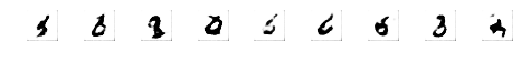

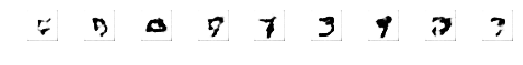

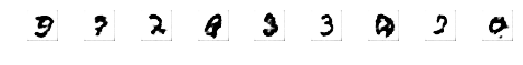

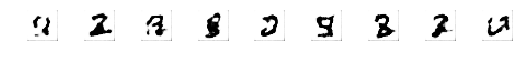

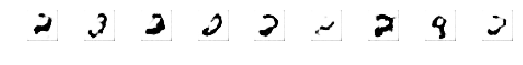

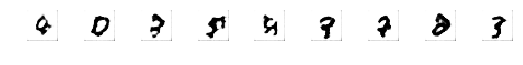

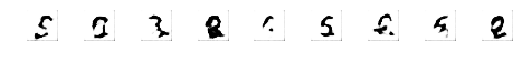

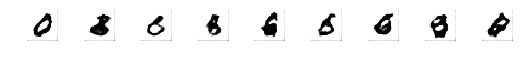

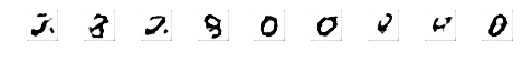

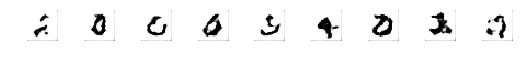

Epoch:2, Step:0, D-Loss:0.174, D-Acc:93.000, G-Loss:5.371, Info-Loss:4.180
Epoch:2, Step:50, D-Loss:0.223, D-Acc:91.000, G-Loss:4.116, Info-Loss:2.768
Epoch:2, Step:100, D-Loss:0.220, D-Acc:91.000, G-Loss:4.227, Info-Loss:2.844
Epoch:2, Step:150, D-Loss:0.296, D-Acc:88.000, G-Loss:3.641, Info-Loss:2.409
Epoch:2, Step:200, D-Loss:0.213, D-Acc:93.000, G-Loss:3.675, Info-Loss:2.528
Epoch:2, Step:250, D-Loss:0.225, D-Acc:91.000, G-Loss:4.508, Info-Loss:3.421
Epoch:2, Step:300, D-Loss:0.247, D-Acc:90.000, G-Loss:3.768, Info-Loss:2.721
Epoch:2, Step:350, D-Loss:0.168, D-Acc:93.000, G-Loss:4.982, Info-Loss:3.861
Epoch:2, Step:400, D-Loss:0.169, D-Acc:96.000, G-Loss:3.731, Info-Loss:2.810
Epoch:2, Step:450, D-Loss:0.193, D-Acc:94.000, G-Loss:2.936, Info-Loss:1.890


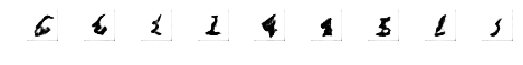

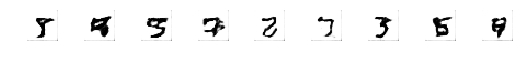

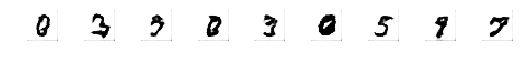

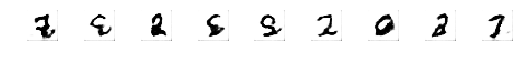

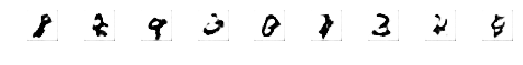

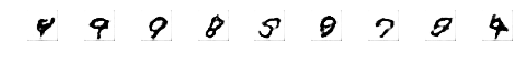

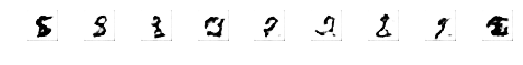

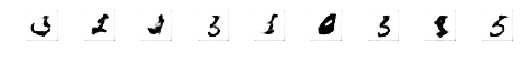

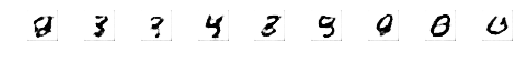

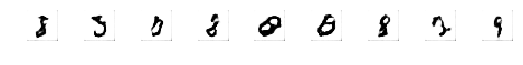

Epoch:3, Step:0, D-Loss:0.220, D-Acc:92.000, G-Loss:3.244, Info-Loss:2.263
Epoch:3, Step:50, D-Loss:0.182, D-Acc:92.000, G-Loss:3.960, Info-Loss:3.080
Epoch:3, Step:100, D-Loss:0.231, D-Acc:87.000, G-Loss:3.906, Info-Loss:2.966
Epoch:3, Step:150, D-Loss:0.263, D-Acc:91.000, G-Loss:4.615, Info-Loss:3.795
Epoch:3, Step:200, D-Loss:0.285, D-Acc:87.000, G-Loss:6.049, Info-Loss:5.282
Epoch:3, Step:250, D-Loss:0.243, D-Acc:89.000, G-Loss:5.494, Info-Loss:4.576
Epoch:3, Step:300, D-Loss:0.139, D-Acc:95.000, G-Loss:4.833, Info-Loss:4.019
Epoch:3, Step:350, D-Loss:0.288, D-Acc:89.000, G-Loss:4.476, Info-Loss:3.712
Epoch:3, Step:400, D-Loss:0.247, D-Acc:88.000, G-Loss:3.283, Info-Loss:2.426
Epoch:3, Step:450, D-Loss:0.449, D-Acc:82.000, G-Loss:5.452, Info-Loss:4.641


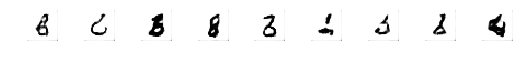

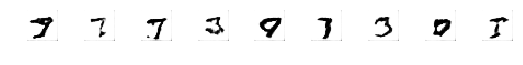

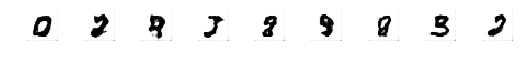

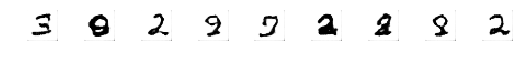

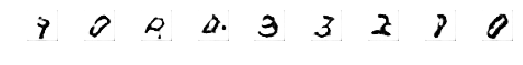

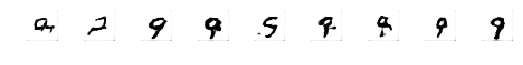

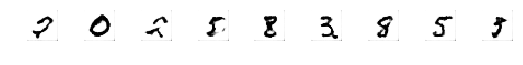

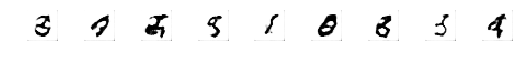

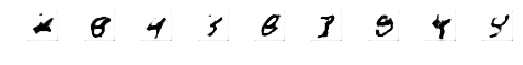

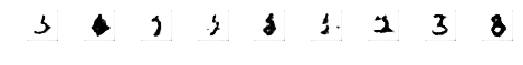

Epoch:4, Step:0, D-Loss:0.286, D-Acc:88.000, G-Loss:4.159, Info-Loss:3.453
Epoch:4, Step:50, D-Loss:0.235, D-Acc:94.000, G-Loss:2.578, Info-Loss:1.856
Epoch:4, Step:100, D-Loss:0.198, D-Acc:94.000, G-Loss:3.640, Info-Loss:2.931
Epoch:4, Step:150, D-Loss:0.298, D-Acc:88.000, G-Loss:2.190, Info-Loss:1.501
Epoch:4, Step:200, D-Loss:0.263, D-Acc:89.000, G-Loss:3.360, Info-Loss:2.620
Epoch:4, Step:250, D-Loss:0.301, D-Acc:86.000, G-Loss:3.315, Info-Loss:2.775
Epoch:4, Step:300, D-Loss:0.202, D-Acc:91.000, G-Loss:2.444, Info-Loss:1.806
Epoch:4, Step:350, D-Loss:0.265, D-Acc:92.000, G-Loss:4.128, Info-Loss:3.505
Epoch:4, Step:400, D-Loss:0.256, D-Acc:92.000, G-Loss:2.730, Info-Loss:2.075
Epoch:4, Step:450, D-Loss:0.259, D-Acc:89.000, G-Loss:3.545, Info-Loss:2.958


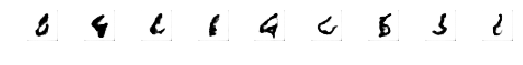

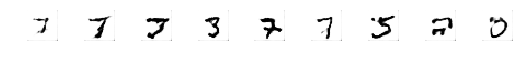

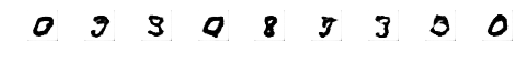

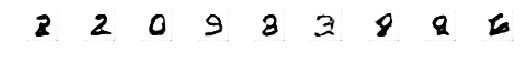

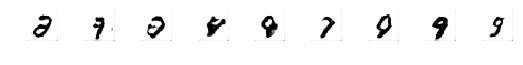

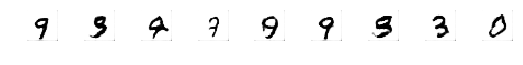

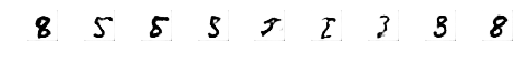

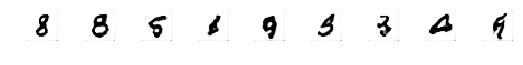

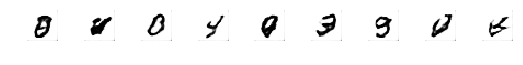

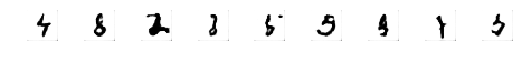

Epoch:5, Step:0, D-Loss:0.177, D-Acc:95.000, G-Loss:1.942, Info-Loss:1.357
Epoch:5, Step:50, D-Loss:0.292, D-Acc:92.000, G-Loss:4.203, Info-Loss:3.649
Epoch:5, Step:100, D-Loss:0.246, D-Acc:89.000, G-Loss:4.299, Info-Loss:3.659
Epoch:5, Step:150, D-Loss:0.239, D-Acc:91.000, G-Loss:3.596, Info-Loss:2.991
Epoch:5, Step:200, D-Loss:0.274, D-Acc:87.000, G-Loss:3.120, Info-Loss:2.593
Epoch:5, Step:250, D-Loss:0.297, D-Acc:88.000, G-Loss:4.379, Info-Loss:3.878
Epoch:5, Step:300, D-Loss:0.365, D-Acc:83.000, G-Loss:2.049, Info-Loss:1.553
Epoch:5, Step:350, D-Loss:0.187, D-Acc:92.000, G-Loss:2.320, Info-Loss:1.814
Epoch:5, Step:400, D-Loss:0.314, D-Acc:87.000, G-Loss:2.697, Info-Loss:2.189
Epoch:5, Step:450, D-Loss:0.247, D-Acc:89.000, G-Loss:2.513, Info-Loss:2.030


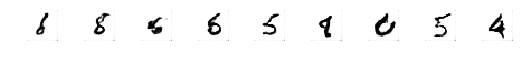

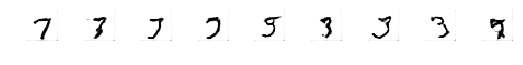

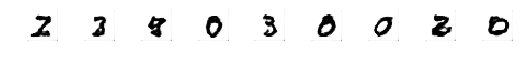

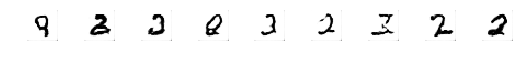

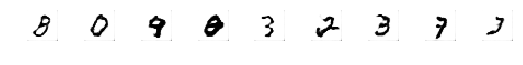

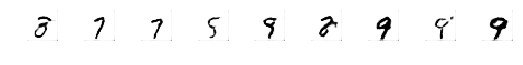

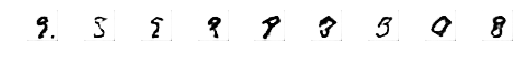

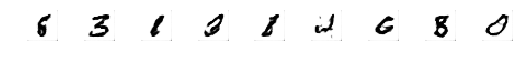

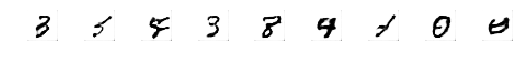

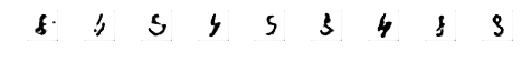

Epoch:6, Step:0, D-Loss:0.318, D-Acc:83.000, G-Loss:4.106, Info-Loss:3.633
Epoch:6, Step:50, D-Loss:0.262, D-Acc:88.000, G-Loss:3.779, Info-Loss:3.279
Epoch:6, Step:100, D-Loss:0.200, D-Acc:92.000, G-Loss:3.496, Info-Loss:3.001


In [ ]:
epochs = 20
batch_size = 100
steps = 500
noise_size = 50

for i in range(0, epochs):
    op = show_generator_results(generator_network)
        #print (op)
    for j in range(steps):
        fake_samples = get_fake_samples(generator_network, batch_size//2, noise_size)
        real_samples = get_real_samples(batch_size=batch_size//2)

        fake_y = np.zeros((batch_size//2, 1))
        real_y = np.ones((batch_size//2, 1))
        
        input_samples = np.vstack((fake_samples, real_samples))
        output_labels = np.vstack((fake_y, real_y))
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d = discriminator_network.train_on_batch(input_samples, output_labels)
        
        noise_batches, control_inputs = get_random_noise(batch_size, noise_size)
        info_gan_input = [noise_batches, control_inputs]
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        d_output = np.ones((batch_size))
        info_output = control_inputs
        info_gan_output = [d_output, info_output]
        
        # Updating Generator weights
        discriminator_network.trainable=False
        loss_g = info_gan_model.train_on_batch(info_gan_input, info_gan_output)
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f, Info-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g[0], loss_g[1]))
            

# Results

In [ ]:
#Generating Unlimited samples
for i in range(2):
    show_generator_results(generator_network)
    print ("-----------------------------------------------------------------------------")